# Phase 1
Download the data from kaggle

In [ ]:
import kagglehub
import os

path = kagglehub.dataset_download("rohanrao/formula-1-world-championship-1950-2020")
files = os.listdir(path)

files

* circuits.csv contains information about the tracks. This doesn't seem like it would be relevant for our data.
* constructors.csv contains information about each constructor. This could be important information. For instance, if a particular constructor outperforms overall, or if a particular field about that constructor correlates with success, that could be interesting.
* constructor_results.csv is redundant information. results.csv has the same information for each driver instead of each constructor. We'll exclude this data.
* drivers.csv contains information about each driver. This will be important data as we predict what qualities make a successful driver.
* driver_standings.csv contains redundant information. results.csv again has the same information. We'll exclude this data
* lap_times.csv contains information about each lap for each driver in each race. For our interests, this seems like it could overcomplicate the model. It could get confused based on the times, since one time for one race could be good, but bad in a different race. We're not exactly concerned with the time, but the order, so we'll exclude this data.
* pit_stops.csv contains information about each pitstop. This seems like it could be important. For instance, we could compare average pitstop duration. However, afer investigating this data, it seems that some info is missing, so we will exclude this data.
* qualifying.csv contains information about qualification rounds (time trials completed before races to see what the start grid will ook like). This data is also missing a lot of values, so we'll exclude this.
* races.csv contains information for each race. Some of this seems important such as the date. We could cross reference this with the driver's date of birth to see his age at the race.
* results.csv contains information for the results of each race. This will be incredibly important. the positionOrder will most likely be our label. grid will be the start position. I'm guessing these two will probably correlate
* seasons.csv just contains years and wikipedia links. We'll drop this
* sprint_results.csv contains redundant information we can get from results.csv
* status.csv just holds information about what the status codes in results.csv mean. We'll most likely drop these, so we can drop this file

That leaves us with constructors, drivers, races, results:

In [3]:
import pandas as pd

constructors_df = pd.read_csv(path + "/constructors.csv")
drivers_df = pd.read_csv(path + "/drivers.csv")
races_df = pd.read_csv(path + "/races.csv")
results_df = pd.read_csv(path + "/results.csv")

## Data Cleaning

Before merging, let's look at the columns in each DataFrame and eliminate ones that won't be helpful

In [4]:
display("Constructors: " + str(constructors_df.columns))
display("Drivers: " + str(drivers_df.columns))
display("Races: " + str(races_df.columns))
display("Results: " + str(results_df.columns))

"Constructors: Index(['constructorId', 'constructorRef', 'name', 'nationality', 'url'], dtype='object')"

"Drivers: Index(['driverId', 'driverRef', 'number', 'code', 'forename', 'surname', 'dob',\n       'nationality', 'url'],\n      dtype='object')"

"Races: Index(['raceId', 'year', 'round', 'circuitId', 'name', 'date', 'time', 'url',\n       'fp1_date', 'fp1_time', 'fp2_date', 'fp2_time', 'fp3_date', 'fp3_time',\n       'quali_date', 'quali_time', 'sprint_date', 'sprint_time'],\n      dtype='object')"

"Results: Index(['resultId', 'raceId', 'driverId', 'constructorId', 'number', 'grid',\n       'position', 'positionText', 'positionOrder', 'points', 'laps', 'time',\n       'milliseconds', 'fastestLap', 'rank', 'fastestLapTime',\n       'fastestLapSpeed', 'statusId'],\n      dtype='object')"

These look like columns that will actually be helpful for our inference task:

Constructors: constructorId, name<br>
Drivers: driverId, forename, surname, dob<br>
Races: raceId, round, date<br>
Results: raceId, driverId, constructorId, grid, positionOrder

Let's extract those columns

In [5]:
pruned_constructors_df = constructors_df[["constructorId", "name"]].copy()
pruned_drivers_df = drivers_df[["driverId", "forename", "surname", "dob"]].copy()
pruned_races_df = races_df[["raceId", "date"]].copy()
pruned_results_df = results_df[["raceId", "driverId", "constructorId", "grid", "positionOrder"]].copy()

Forename and surname are only really valuable together. Let's combine those into one field.

In [6]:
pruned_drivers_df["driverName"] = pruned_drivers_df["forename"] + " " + pruned_drivers_df["surname"]
pruned_drivers_df = pruned_drivers_df.drop("forename", axis=1)
pruned_drivers_df = pruned_drivers_df.drop("surname", axis=1)
pruned_drivers_df.head()

,driverId,dob,driverName
0,1,1985-01-07,Lewis Hamilton
1,2,1977-05-10,Nick Heidfeld
2,3,1985-06-27,Nico Rosberg
3,4,1981-07-29,Fernando Alonso
4,5,1981-10-19,Heikki Kovalainen


Let's also rename grid to startPosition and positionOrder to endPosition. Those names are a bit more intuitive.

In [7]:
pruned_results_df = pruned_results_df.rename(columns={
    "grid": "startPosition",
    "positionOrder": "endPosition"
})
pruned_results_df.head()

,raceId,driverId,constructorId,startPosition,endPosition
0,18,1,1,1,1
1,18,2,2,5,2
2,18,3,3,7,3
3,18,4,4,11,4
4,18,5,1,3,5


The constructor name is also just labeled 'name' right now. Let's change that to constructorName.

In [8]:
pruned_constructors_df = pruned_constructors_df.rename(columns={
    "name": "constructorName"
})
pruned_constructors_df.head()

,constructorId,constructorName
0,1,McLaren
1,2,BMW Sauber
2,3,Williams
3,4,Renault
4,5,Toro Rosso


Let's merge our cleaned columns together using constructorId, driverId, and raceId

In [9]:
merged_df = pd.merge(pruned_results_df, pruned_constructors_df, on="constructorId")
merged_df = pd.merge(merged_df, pruned_drivers_df, on="driverId")
merged_df = pd.merge(merged_df, pruned_races_df, on="raceId")

merged_df.describe()

,raceId,driverId,constructorId,startPosition,endPosition
count,26759.000000,26759.000000,26759.000000,26759.000000,26759.000000
mean,551.687283,278.673530,50.180537,11.134796,12.794051
std,313.265036,282.703039,61.551498,7.202860,7.665951
min,1.000000,1.000000,1.000000,0.000000,1.000000
25%,300.000000,57.000000,6.000000,5.000000,6.000000
50%,531.000000,172.000000,25.000000,11.000000,12.000000
75%,811.000000,399.500000,63.000000,17.000000,18.000000
max,1144.000000,862.000000,215.000000,34.000000,39.000000


Date and dob don't seem to be super helpful as a metric by themselves. Let's convert dob into an age field for the driver. Let's also convert the date into an experience indicator for both the driver and the constructor.

In [10]:
merged_df["dob"] = pd.to_datetime(merged_df["dob"])
merged_df["date"] = pd.to_datetime(merged_df["date"])

merged_df["driverAge"] = merged_df["date"] - merged_df["dob"]
merged_df = merged_df.drop('dob', axis=1)
merged_df.head()

,raceId,driverId,constructorId,startPosition,endPosition,constructorName,driverName,date,driverAge
0,18,1,1,1,1,McLaren,Lewis Hamilton,2008-03-16,8469 days
1,18,5,1,3,5,McLaren,Heikki Kovalainen,2008-03-16,9645 days
2,18,4,4,11,4,Renault,Fernando Alonso,2008-03-16,9727 days
3,18,8,6,15,8,Ferrari,Kimi Räikkönen,2008-03-16,10378 days
4,18,14,9,8,14,Red Bull,David Coulthard,2008-03-16,13504 days


In [11]:
merged_df["driverExperience"] = merged_df["date"] - merged_df.groupby("driverId")["date"].transform('min')
merged_df["constructorExperience"] = merged_df["date"] - merged_df.groupby("constructorId")["date"].transform('min')
merged_df.head()

,raceId,driverId,constructorId,startPosition,endPosition,constructorName,driverName,date,driverAge,driverExperience,constructorExperience
0,18,1,1,1,1,McLaren,Lewis Hamilton,2008-03-16,8469 days,364 days,14469 days
1,18,5,1,3,5,McLaren,Heikki Kovalainen,2008-03-16,9645 days,364 days,14469 days
2,18,4,4,11,4,Renault,Fernando Alonso,2008-03-16,9727 days,2569 days,11201 days
3,18,8,6,15,8,Ferrari,Kimi Räikkönen,2008-03-16,10378 days,2569 days,21119 days
4,18,14,9,8,14,Red Bull,David Coulthard,2008-03-16,13504 days,5040 days,1106 days


Before we start making observations, we need to convert our time objects into ints in order to effectively use them. Let's convert them all into years. This will ensure that we can intuitely see what the numbers mean (days would be too confusing), and also provide a scale for the model to hopefully use (e.g. 800 days to 801 days doesn't really matter, but 30 years to 31 years may). 

In [12]:
merged_df['driverAge'] = merged_df['driverAge'].dt.days / 365
merged_df['driverExperience'] = merged_df['driverExperience'].dt.days / 365
merged_df['constructorExperience'] = merged_df['constructorExperience'].dt.days / 365

merged_df.describe()

,raceId,driverId,constructorId,startPosition,endPosition,date,driverAge,driverExperience,constructorExperience
count,26759.000000,26759.000000,26759.000000,26759.000000,26759.000000,26759,26759.000000,26759.000000,26759.000000
mean,551.687283,278.673530,50.180537,11.134796,12.794051,1991-12-03 01:27:10.688740352,30.013506,4.727580,16.490770
min,1.000000,1.000000,1.000000,0.000000,1.000000,1950-05-13 00:00:00,17.465753,0.000000,0.000000
25%,300.000000,57.000000,6.000000,5.000000,6.000000,1977-05-08 00:00:00,26.161644,1.342466,2.571233
50%,531.000000,172.000000,25.000000,11.000000,12.000000,1991-09-08 00:00:00,29.449315,3.682192,8.306849
75%,811.000000,399.500000,63.000000,17.000000,18.000000,2009-05-10 00:00:00,33.315068,7.095890,24.145205
max,1144.000000,862.000000,215.000000,34.000000,39.000000,2024-12-08 00:00:00,58.827397,23.780822,74.602740
std,313.265036,282.703039,61.551498,7.202860,7.665951,NaN,5.272122,4.150545,18.628608


There also seems to be some anomolies. There should only be 20 cars per race (2 per constructor and 10 constructors in any given season). A start/end position over that doesn't make any sense. Let's remove any rows with points greater than 25. Let's also remove any rows where startPosition or endPosition is greater than 20.

In [13]:
merged_df = merged_df[merged_df['startPosition'] <= 20]
merged_df = merged_df[merged_df['endPosition'] <= 20]

merged_df.head()

,raceId,driverId,constructorId,startPosition,endPosition,constructorName,driverName,date,driverAge,driverExperience,constructorExperience
0,18,1,1,1,1,McLaren,Lewis Hamilton,2008-03-16,23.202740,0.997260,39.641096
1,18,5,1,3,5,McLaren,Heikki Kovalainen,2008-03-16,26.424658,0.997260,39.641096
2,18,4,4,11,4,Renault,Fernando Alonso,2008-03-16,26.649315,7.038356,30.687671
3,18,8,6,15,8,Ferrari,Kimi Räikkönen,2008-03-16,28.432877,7.038356,57.860274
4,18,14,9,8,14,Red Bull,David Coulthard,2008-03-16,36.997260,13.808219,3.030137


Lastly, we'll make an explicit label column which will be True if the driver is within the top 5 end positions.

In [14]:
merged_df['inTop5'] = merged_df['endPosition'] <= 5

Let's look at some plots and see if we can make any conclusions. (Some AI was used in this section to help better represent graphs)

PS: This next code block takes awhile to run (~10m)

In [15]:
import seaborn as sns
#sns.pairplot(data=merged_df, vars=["startPosition", "driverAge", "driverExperience", "constructorExperience"], hue='inTop5', kind='kde', plot_kws={'fill': True}, diag_kws={'fill': True})

### Observations
* interestingly constructors seem to be young most of the time. Those that are new (within 10 years or so) seem to have a much higher profile of drivers who don't finish top 5.
* startPosition and being in the top 5 are correlated. Those that start at the front of the pack seem to have a higher chance of staying there.

Let's look more closely at the correlation between start and end position:
### startPosition vs endPosition

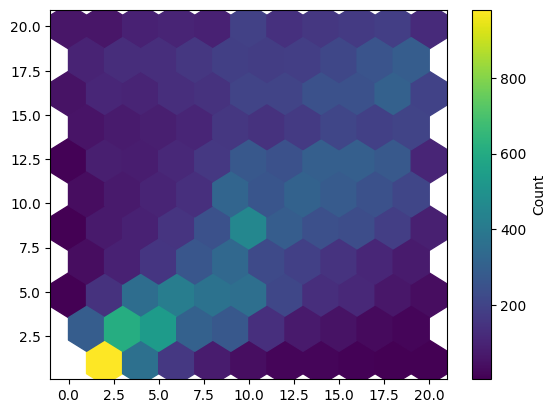

In [16]:
import matplotlib.pyplot as plt

hb = plt.hexbin(merged_df['startPosition'], merged_df['endPosition'], gridsize=10, cmap='viridis', mincnt=1)
plt.colorbar(hb, label='Count')
plt.show()

This demonstrates the correlation between start position and end position nicely. Drivers that start near the front seem to be more likely to end near the front. Drivers that start in the back seem to move up more so than drivers in the front move back.

### Heatmap

<Axes: >

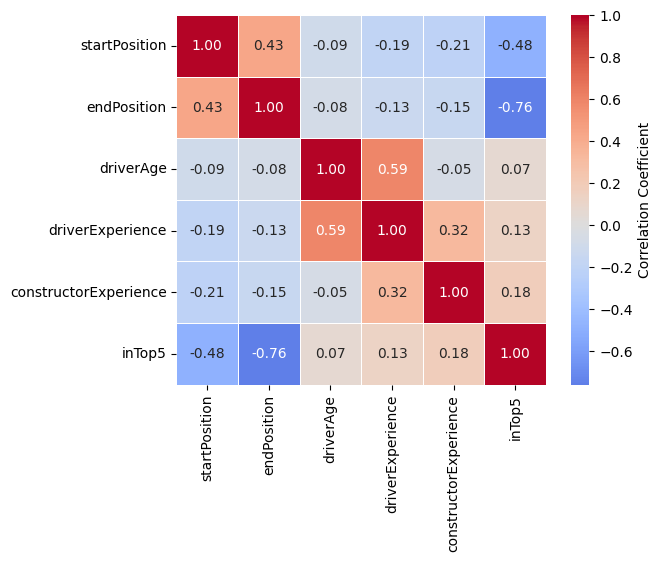

In [17]:
corr = merged_df[["startPosition", "endPosition", "driverAge", "driverExperience", "constructorExperience", "inTop5"]].corr()
sns.heatmap(
    corr,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={'label': 'Correlation Coefficient'}
)

Some interesting observations here:
* driver experience correlates with constructor experience, but driver age does not
* despite that, driver age correlates well with driver experience
* start position again correlates with being in the top 5 well


Before training, let's make endPosition and startPosition 0-indexed.

In [113]:
merged_df['endPosition'] = merged_df['endPosition'] - 1
merged_df['startPosition'] = merged_df['startPosition'] - 1

# Phase 2

## Models

### Basic Data

#### Model

Let's see if we can create a model with these raw values to predict if the driver will be in the top 5. The below code was based on the tensorflow example done in class. Some customizations have been made though that required more research. For instance, layers, activation, output_activation, and l2 were all added as inputs. Layers enables us to make a neural network instead of a simple linear regression model. Activation allows us to define the activation function for the hidden layers. Output_activation allows us to define the activation function for the output layer. L2 allows us to add an L2 regularization factor into our training. Note too that the lab model was a regression model, but this is a categorical model. Some other customizations had to happen for that such as redefining the loss function and adding other metrics.

In [114]:
import tensorflow as tf

def build_model(learning_rate, layers, activation, output_activation, l2=0):
    """
    layers should be a list of integers describing the layers of the model. For instance, [4, 5, 3, 2] would describe
    a model with two hidden layers, the first having 5 neurons, and the second having 3 layers. The input layer would
    have 4 inputs, and the output layer would have 2 neurons.
    """

    model = tf.keras.models.Sequential()
    
    model.add(tf.keras.layers.Dense(
        layers[1], 
        activation=activation, 
        input_shape=(layers[0],),
        kernel_regularizer=tf.keras.regularizers.l2(l2)
    ))

    for i in range(2, len(layers) - 1):
        model.add(tf.keras.layers.Dense(
            layers[i], 
            activation=activation,
            kernel_regularizer=tf.keras.regularizers.l2(l2)
        ))

    model.add(tf.keras.layers.Dense(
        layers[len(layers) - 1], 
        activation=output_activation,
        kernel_regularizer=tf.keras.regularizers.l2(l2)
    ))
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                loss="binary_crossentropy",
                metrics=[
                    'accuracy',
                    tf.keras.metrics.Precision(name='precision'),
                    tf.keras.metrics.Recall(name='recall'),
                    tf.keras.metrics.AUC(curve='ROC', name='auc')
                    ]
                )

    return model

def train_model(model, train_features, train_labels, test_features, test_labels, epochs, batch_size):

    history = model.fit(x=train_features, 
                        y=train_labels, 
                        validation_data=(test_features, test_labels), 
                        batch_size=batch_size, 
                        epochs=epochs)

    trained_weight = model.get_weights()[0]
    trained_bias = model.get_weights()[1]

    epochs_ran = history.epoch
    hist = pd.DataFrame(history.history)
    train_loss = hist["loss"]
    test_loss = hist["val_loss"]

    return trained_weight, trained_bias, epochs_ran, train_loss, test_loss


def plot_the_loss_curve(epochs, train_loss, test_loss):
    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("Loss")

    plt.plot(epochs, train_loss, label="Train Loss")
    plt.plot(epochs, test_loss, label="Test Loss")
    plt.legend()
    low = min(train_loss.min(), test_loss.min())
    high = max(train_loss.max(), test_loss.max())
    plt.ylim([low*0.97, high])
    plt.show()

In [115]:
from sklearn.model_selection import train_test_split

features = merged_df[["startPosition", "driverAge", "driverExperience", "constructorExperience"]].values
labels = merged_df['inTop5']

X_train, X_test, Y_train, Y_test = train_test_split(features, labels, test_size=0.2, shuffle=True)

Epoch 1/100


c:\Users\HADLEYHR23\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.7346 - auc: 0.7425 - loss: 0.5206 - precision: 0.5665 - recall: 0.1781 - val_accuracy: 0.7876 - val_auc: 0.8166 - val_loss: 0.4654 - val_precision: 0.6750 - val_recall: 0.4759
Epoch 2/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7846 - auc: 0.8121 - loss: 0.4599 - precision: 0.6468 - recall: 0.4897 - val_accuracy: 0.7859 - val_auc: 0.8240 - val_loss: 0.4539 - val_precision: 0.6290 - val_recall: 0.5865
Epoch 3/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7839 - auc: 0.8169 - loss: 0.4548 - precision: 0.6319 - recall: 0.5266 - val_accuracy: 0.7854 - val_auc: 0.8247 - val_loss: 0.4523 - val_precision: 0.6371 - val_recall: 0.5549
Epoch 4/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7856 - auc: 0.8179 - loss: 0.4536 - precision: 0.6343 - recall: 0.5335 - val_accuracy: 0.7874 - val_auc: 0.8256 - val_loss: 0.4503 - val_precision: 0.6477 - val_recall: 0.5391
Epoch 5/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/s

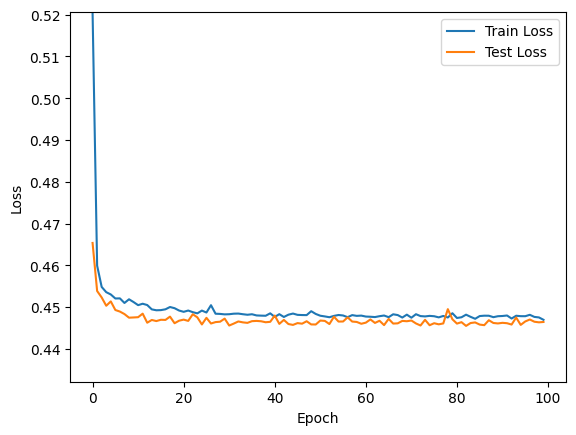

In [116]:
model = build_model(0.005, [4, 10, 1], activation="sigmoid", output_activation="sigmoid")

weight, bias, epochs, train_loss, test_loss = train_model(model, 
                                                          X_train,
                                                          Y_train,
                                                          X_test,
                                                          Y_test,
                                                          epochs=100, 
                                                          batch_size=200
)
plot_the_loss_curve(epochs, train_loss, test_loss)

Our auc indicates our model separates decently between our classes. Our precision says that a little over 60% of the drivers predicted to finish top 5 actually do finish top 5. Our recall says that of the drivers that actually finish top 5, we only catch 53% of them. Both of those metrics aren't great. Even though accuracy is 78%, we can easily get an accuracy of 75% by guessing false on everything.

#### ROC

127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


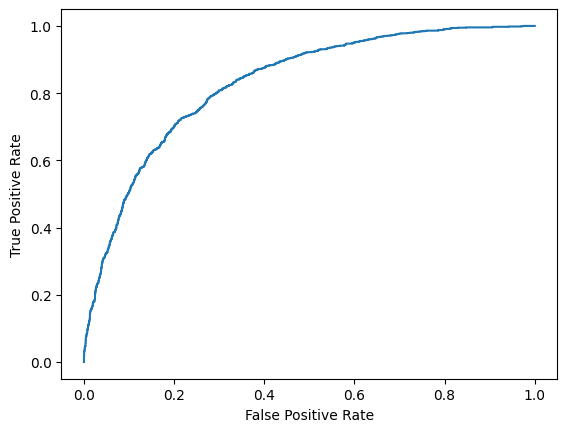

In [117]:
from sklearn.metrics import roc_curve
import numpy as np

predictions = model.predict(X_test)
fpr, tpr, thresholds = roc_curve(Y_test, predictions)

plt.figure()
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

As our auc indicated, our roc curve is good

#### Confusion Matrix

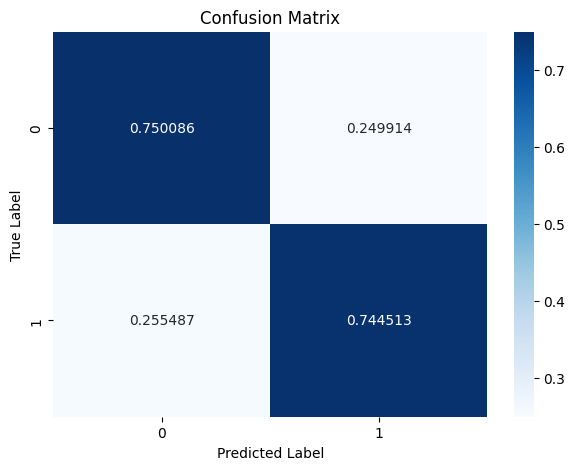

In [118]:
above_threshold = predictions > 0.3
confusion_matrix = tf.math.confusion_matrix(Y_test, above_threshold).numpy()
normalized_matrix = confusion_matrix / confusion_matrix.sum(axis=1, keepdims=True)
plt.figure(figsize=(7, 5))
sns.heatmap(normalized_matrix, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

That's actually pretty good. Our model is correctly identifying 74% of the drivers that finish in the top 5. However, we did have to set our threshold fairly low. That could produce false positives in the long run. That's also a bit counterintuitive. We should predict True less than we predict False. If we have to skew our threshold, we should be skewing it up to reduce the amount of trues our model predicts. Let's see if binning and other methods help.

### Binning

Let's bin age and experience. For age, it shouldn't really matter if someone is 25 or 26. It could matter if someone is 25 vs 35 though. Same for experience. It probably doesn't matter if someone has been racing for 5 years vs 6 years. But it could matter if someone has been racing for 5 years vs 15 years. Binning can help clarify these things.

<Axes: ylabel='Frequency'>

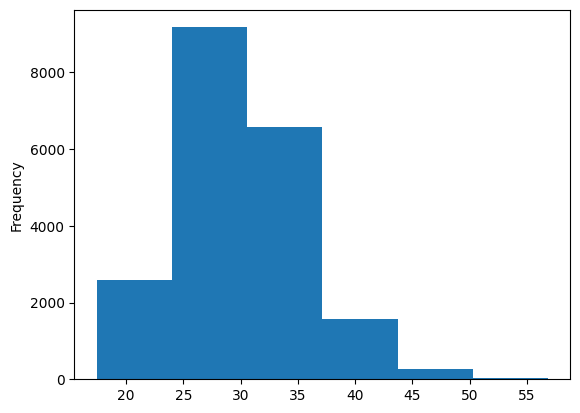

In [189]:
merged_df['driverAge'].plot.hist(bins=6)

We'll bin everyone under 25, everyone between 25 and 35, and everyone over 35. This should reflect the idea of young, middle, and old. In other words, drivers who are relatively young for the sport, drivers who are relatively middle-aged for the sport, and drivers who are old for the sport.

In [120]:
merged_df['binnedDriverAge'] = pd.cut(merged_df['driverAge'], right=True, bins=[0, 25, 35, 60], labels=['Young', 'Middle', 'Old'])
merged_df.head()

,raceId,driverId,constructorId,startPosition,endPosition,constructorName,driverName,date,driverAge,driverExperience,constructorExperience,inTop5,binnedDriverAge,binnedDriverExperience,binnedConstructorExperience
0,18,1,1,0,0,McLaren,Lewis Hamilton,2008-03-16,23.202740,0.997260,39.641096,True,Young,Rookie,Experienced
1,18,5,1,2,4,McLaren,Heikki Kovalainen,2008-03-16,26.424658,0.997260,39.641096,True,Middle,Rookie,Experienced
2,18,4,4,10,3,Renault,Fernando Alonso,2008-03-16,26.649315,7.038356,30.687671,True,Middle,Experienced,Experienced
3,18,8,6,14,7,Ferrari,Kimi Räikkönen,2008-03-16,28.432877,7.038356,57.860274,False,Middle,Experienced,Experienced
4,18,14,9,7,13,Red Bull,David Coulthard,2008-03-16,36.997260,13.808219,3.030137,False,Old,Veteran,Rookie


<Axes: ylabel='Frequency'>

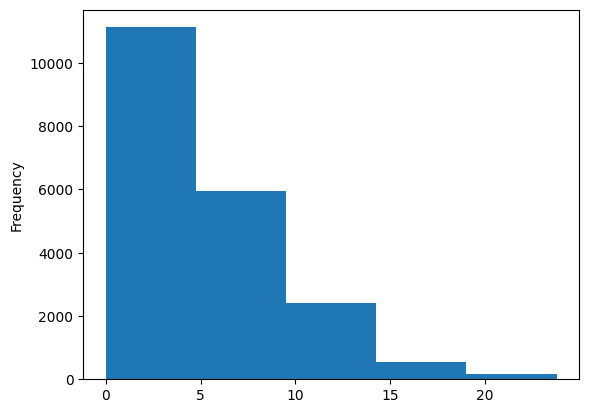

In [121]:
merged_df["driverExperience"].plot.hist(bins=5)

For driver experience, we'll bin everyone with 0 to 5 years of experience. This will be the rookies. We'll bin everyone with 5 to 10 years of experience. This will be experienced drivers. And we'll bin everyone with 10+ years of experience. These will be the veterans.

In [122]:
merged_df['binnedDriverExperience'] = pd.cut(merged_df['driverExperience'], right=True, bins=[0,5,10,30], labels=['Rookie', 'Experienced', 'Veteran'])
merged_df.head()

,raceId,driverId,constructorId,startPosition,endPosition,constructorName,driverName,date,driverAge,driverExperience,constructorExperience,inTop5,binnedDriverAge,binnedDriverExperience,binnedConstructorExperience
0,18,1,1,0,0,McLaren,Lewis Hamilton,2008-03-16,23.202740,0.997260,39.641096,True,Young,Rookie,Experienced
1,18,5,1,2,4,McLaren,Heikki Kovalainen,2008-03-16,26.424658,0.997260,39.641096,True,Middle,Rookie,Experienced
2,18,4,4,10,3,Renault,Fernando Alonso,2008-03-16,26.649315,7.038356,30.687671,True,Middle,Experienced,Experienced
3,18,8,6,14,7,Ferrari,Kimi Räikkönen,2008-03-16,28.432877,7.038356,57.860274,False,Middle,Experienced,Experienced
4,18,14,9,7,13,Red Bull,David Coulthard,2008-03-16,36.997260,13.808219,3.030137,False,Old,Veteran,Rookie


<Axes: ylabel='Frequency'>

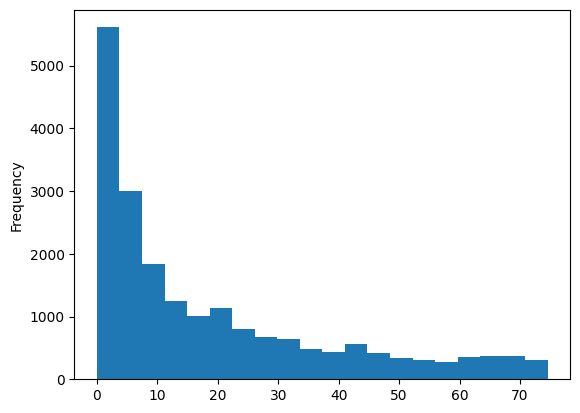

In [124]:
merged_df['constructorExperience'].plot.hist(bins=20)

There's much less here than there was for age and driver experience. It looks like there are a lot of constructors with not a lot of experience. Then there's everyone else. To reflect that, we'll bin constructors with 0 to 5 years of experience. These will be the rookies. And we'll bin constructors with 5+ years of experience. These will be the experienced constructors.

In [125]:
merged_df['binnedConstructorExperience'] = pd.cut(merged_df['constructorExperience'], right=True, bins=[0,5,80], labels=['Rookie', 'Experienced'])
merged_df.head()

,raceId,driverId,constructorId,startPosition,endPosition,constructorName,driverName,date,driverAge,driverExperience,constructorExperience,inTop5,binnedDriverAge,binnedDriverExperience,binnedConstructorExperience
0,18,1,1,0,0,McLaren,Lewis Hamilton,2008-03-16,23.202740,0.997260,39.641096,True,Young,Rookie,Experienced
1,18,5,1,2,4,McLaren,Heikki Kovalainen,2008-03-16,26.424658,0.997260,39.641096,True,Middle,Rookie,Experienced
2,18,4,4,10,3,Renault,Fernando Alonso,2008-03-16,26.649315,7.038356,30.687671,True,Middle,Experienced,Experienced
3,18,8,6,14,7,Ferrari,Kimi Räikkönen,2008-03-16,28.432877,7.038356,57.860274,False,Middle,Experienced,Experienced
4,18,14,9,7,13,Red Bull,David Coulthard,2008-03-16,36.997260,13.808219,3.030137,False,Old,Veteran,Rookie


We'll one hot encode age and experience

In [126]:
encoded_df = pd.get_dummies(merged_df, columns=["binnedDriverAge", "binnedDriverExperience", "binnedConstructorExperience"], drop_first=True)
encoded_df.head()

,raceId,driverId,constructorId,startPosition,endPosition,constructorName,driverName,date,driverAge,driverExperience,constructorExperience,inTop5,binnedDriverAge_Middle,binnedDriverAge_Old,binnedDriverExperience_Experienced,binnedDriverExperience_Veteran,binnedConstructorExperience_Experienced
0,18,1,1,0,0,McLaren,Lewis Hamilton,2008-03-16,23.202740,0.997260,39.641096,True,False,False,False,False,True
1,18,5,1,2,4,McLaren,Heikki Kovalainen,2008-03-16,26.424658,0.997260,39.641096,True,True,False,False,False,True
2,18,4,4,10,3,Renault,Fernando Alonso,2008-03-16,26.649315,7.038356,30.687671,True,True,False,True,False,True
3,18,8,6,14,7,Ferrari,Kimi Räikkönen,2008-03-16,28.432877,7.038356,57.860274,False,True,False,True,False,True
4,18,14,9,7,13,Red Bull,David Coulthard,2008-03-16,36.997260,13.808219,3.030137,False,False,True,False,True,False


Finally, we'll convert those true/false values into 1/0 values so our model can process them

In [127]:
encoded_df['binnedDriverAge_Middle']                  = encoded_df['binnedDriverAge_Middle'].astype(int)
encoded_df['binnedDriverAge_Old']                     = encoded_df['binnedDriverAge_Old'].astype(int)
encoded_df['binnedDriverExperience_Experienced']      = encoded_df['binnedDriverExperience_Experienced'].astype(int)
encoded_df['binnedDriverExperience_Veteran']          = encoded_df['binnedDriverExperience_Veteran'].astype(int)
encoded_df['binnedConstructorExperience_Experienced'] = encoded_df['binnedConstructorExperience_Experienced'].astype(int)
encoded_df.head()


,raceId,driverId,constructorId,startPosition,endPosition,constructorName,driverName,date,driverAge,driverExperience,constructorExperience,inTop5,binnedDriverAge_Middle,binnedDriverAge_Old,binnedDriverExperience_Experienced,binnedDriverExperience_Veteran,binnedConstructorExperience_Experienced
0,18,1,1,0,0,McLaren,Lewis Hamilton,2008-03-16,23.202740,0.997260,39.641096,True,0,0,0,0,1
1,18,5,1,2,4,McLaren,Heikki Kovalainen,2008-03-16,26.424658,0.997260,39.641096,True,1,0,0,0,1
2,18,4,4,10,3,Renault,Fernando Alonso,2008-03-16,26.649315,7.038356,30.687671,True,1,0,1,0,1
3,18,8,6,14,7,Ferrari,Kimi Räikkönen,2008-03-16,28.432877,7.038356,57.860274,False,1,0,1,0,1
4,18,14,9,7,13,Red Bull,David Coulthard,2008-03-16,36.997260,13.808219,3.030137,False,0,1,0,1,0


#### Model
Let's see what our model does now that we've binned some values

Epoch 1/100


c:\Users\HADLEYHR23\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.4246 - auc: 0.4827 - loss: 1.0065 - precision: 0.2712 - recall: 0.6428 - val_accuracy: 0.7097 - val_auc: 0.7952 - val_loss: 0.5922 - val_precision: 0.4297 - val_recall: 0.0476
Epoch 2/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7668 - auc: 0.7908 - loss: 0.5569 - precision: 0.6570 - recall: 0.3247 - val_accuracy: 0.7715 - val_auc: 0.8086 - val_loss: 0.5392 - val_precision: 0.6491 - val_recall: 0.4372
Epoch 3/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7853 - auc: 0.7921 - loss: 0.5161 - precision: 0.6490 - recall: 0.4834 - val_accuracy: 0.7757 - val_auc: 0.8081 - val_loss: 0.5116 - val_precision: 0.6358 - val_recall: 0.5048
Epoch 4/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7868 - auc: 0.8050 - loss: 0.4939 - precision: 0.6450 - recall: 0.5063 - val_accuracy: 0.7797 - val_auc: 0.8076 - val_loss: 0.4968 - val_precision: 0.6370 - val_recall: 0.5333
Epoch 5/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/s

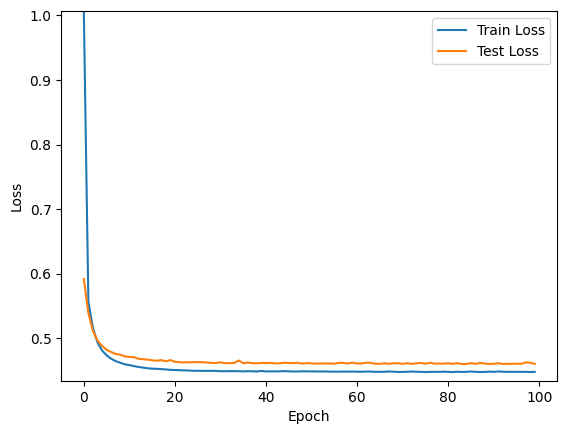

In [128]:
features = encoded_df[["startPosition", 
                        "binnedDriverAge_Middle", 
                        "binnedDriverAge_Old",
                        "binnedDriverExperience_Experienced",
                        "binnedDriverExperience_Veteran",
                        "binnedConstructorExperience_Experienced"
                      ]].values
labels = encoded_df['inTop5']

X_train, X_test, Y_train, Y_test = train_test_split(features, labels, test_size=0.2, shuffle=True)

model = build_model(0.01, [6, 4, 1], activation="sigmoid", output_activation="sigmoid")
weight, bias, epochs, train_loss, test_loss = train_model(
    model, 
    X_train,
    Y_train,
    X_test,
    Y_test,
    epochs=100, 
    batch_size=200, 
)

plot_the_loss_curve(epochs, train_loss, test_loss)

We're overfitting a tiny bit here, but not by much. Our accuracy is fairly high, but accuracy isn't the best metric. AUC is really strong, and precision is indicating that we are predicting true positives. Our recall though could be better. That means that of the drivers who actually finish top 5, we're only getting about half of them.

#### ROC

127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


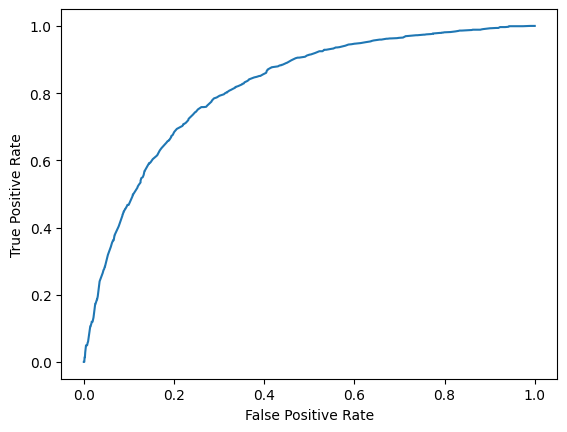

In [129]:
predictions = model.predict(X_test)
fpr, tpr, thresholds = roc_curve(Y_test, predictions)

plt.figure()
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

As AUC indicated, our ROC curve is strong. We are diving between top 5 finishers and non-top 5 finishers. Our threshold may need to be adjusted though.

#### Confusion Matrix

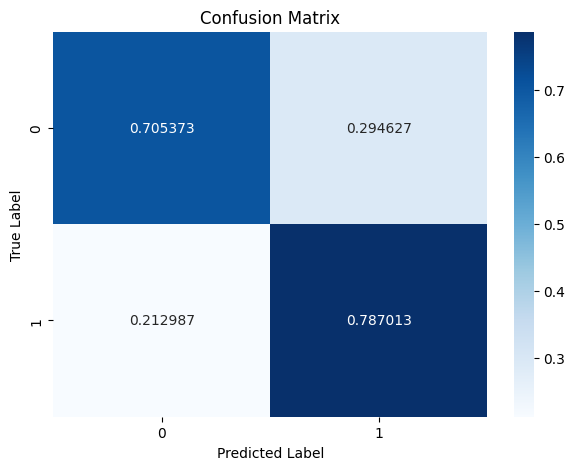

In [130]:
above_threshold = predictions > 0.3
confusion_matrix = tf.math.confusion_matrix(Y_test, above_threshold).numpy()
normalized_matrix = confusion_matrix / confusion_matrix.sum(axis=1, keepdims=True)
plt.figure(figsize=(7, 5))
sns.heatmap(normalized_matrix, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

Our true positive rate has increased by a couple of marks, but our false negative rate has dropped a little. Binning has taken away some certainty for identifying non top 5 finishers while increasing certainty for top 5 finishers. However, our threshold had to be lowered for this result. As mentioned above, this isn't a good sign.

### Synthetic Features
It would be great if we could create a synthetic feature that speaks to how drivers have done in the last couple of races. If a driver performs well in the last 5 races, then they will probably be more likely to perform well in the current race.

There are a number of ways we could model this. We could see what their average change in position is for the past 5 races. We could see how many races out of the past 5 were in the top 5 endPositions. We could see when the last time they finished in the top 5. We could also look at a streak of finishes in the top 5.

I think the most predictive would be how many races out of the past 5 were in the top 5 endPositions, or the streak of finishes in the top 5. For the amount of top 5 finishes we'll do a ratio of races_in_top_5 / total_races_measured. For the streak we'll just do the raw number.

In [131]:
n_races = 5
placing_threshold = 5

sorted_df = encoded_df.sort_values(by=['driverId', 'date'])
sorted_df['top5Percent'] = 0.0
sorted_df['top5Streak'] = 0

for driver in sorted_df['driverId'].unique():

    driver_data = sorted_df[sorted_df['driverId'] == driver]
    streak = 0

    for i in range(len(driver_data)):
        # Get the last number of races
        last_races = driver_data.iloc[max(0, i-n_races):i]

        # Count how many are below the threshold and assign that number
        count = (last_races['endPosition'] <= placing_threshold).sum()
        sorted_df.loc[driver_data.index[i], 'top5Percent'] = count / n_races

        # If the place of the last race was below the threshold, increment
        if driver_data.iloc[i-1]['endPosition'] <= placing_threshold:
            streak += 1
        else:
            streak = 0

        sorted_df.loc[driver_data.index[i], 'top5Streak'] = streak

sorted_df.head()

,raceId,driverId,constructorId,startPosition,endPosition,constructorName,driverName,date,driverAge,driverExperience,constructorExperience,inTop5,binnedDriverAge_Middle,binnedDriverAge_Old,binnedDriverExperience_Experienced,binnedDriverExperience_Veteran,binnedConstructorExperience_Experienced,top5Percent,top5Streak
368,36,1,1,3,2,McLaren,Lewis Hamilton,2007-03-18,22.205479,0.000000,38.643836,True,0,0,0,0,1,0.0,1
390,37,1,1,3,1,McLaren,Lewis Hamilton,2007-04-08,22.263014,0.057534,38.701370,True,0,0,0,0,1,0.2,2
412,38,1,1,1,1,McLaren,Lewis Hamilton,2007-04-15,22.282192,0.076712,38.720548,True,0,0,0,0,1,0.4,3
434,39,1,1,3,1,McLaren,Lewis Hamilton,2007-05-13,22.358904,0.153425,38.797260,True,0,0,0,0,1,0.6,4
456,40,1,1,1,1,McLaren,Lewis Hamilton,2007-05-27,22.397260,0.191781,38.835616,True,0,0,0,0,1,0.8,5


What if we did an average placing over the last 5 races too. We could also do an average delta between start and end position over the last 5 races.

In [167]:
n_races = 5

momentum_df = sorted_df.sort_values(by=['driverId', 'date'])


momentum_df['lastAverageEndPosition'] = 0.0
momentum_df['lastAveragePositionDelta'] = 0.0

for driver in momentum_df['driverId'].unique():

    driver_data = momentum_df[momentum_df['driverId'] == driver]

    for i in range(len(driver_data)):
        # Get the last number of races
        last_races = driver_data.iloc[max(0, i-n_races):i]

        if len(last_races) > 0:
            momentum_df.loc[driver_data.index[i], 'lastAverageEndPosition'] = last_races['endPosition'].mean()

            deltas = last_races['startPosition'] - last_races['endPosition']
            momentum_df.loc[driver_data.index[i], 'lastAveragePositionDelta'] = deltas.mean()
        else:
            momentum_df.loc[driver_data.index[i], 'lastAverageEndPosition'] = 0
            momentum_df.loc[driver_data.index[i], 'lastAveragePositionDelta'] = 0

momentum_df.head()

,raceId,driverId,constructorId,startPosition,endPosition,constructorName,driverName,date,driverAge,driverExperience,...,inTop5,binnedDriverAge_Middle,binnedDriverAge_Old,binnedDriverExperience_Experienced,binnedDriverExperience_Veteran,binnedConstructorExperience_Experienced,top5Percent,top5Streak,lastAverageEndPosition,lastAveragePositionDelta
368,36,1,1,3,2,McLaren,Lewis Hamilton,2007-03-18,22.205479,0.000000,...,True,0,0,0,0,1,0.0,1,0.000000,0.00
390,37,1,1,3,1,McLaren,Lewis Hamilton,2007-04-08,22.263014,0.057534,...,True,0,0,0,0,1,0.2,2,2.000000,1.00
412,38,1,1,1,1,McLaren,Lewis Hamilton,2007-04-15,22.282192,0.076712,...,True,0,0,0,0,1,0.4,3,1.500000,1.50
434,39,1,1,3,1,McLaren,Lewis Hamilton,2007-05-13,22.358904,0.153425,...,True,0,0,0,0,1,0.6,4,1.333333,1.00
456,40,1,1,1,1,McLaren,Lewis Hamilton,2007-05-27,22.397260,0.191781,...,True,0,0,0,0,1,0.8,5,1.250000,1.25


#### Model

Epoch 1/200


c:\Users\HADLEYHR23\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.7165 - auc: 0.7163 - loss: 0.5402 - precision: 0.4833 - recall: 0.2446 - val_accuracy: 0.7691 - val_auc: 0.8112 - val_loss: 0.4774 - val_precision: 0.6673 - val_recall: 0.3165
Epoch 2/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7882 - auc: 0.8268 - loss: 0.4535 - precision: 0.6798 - recall: 0.4547 - val_accuracy: 0.7842 - val_auc: 0.8206 - val_loss: 0.4596 - val_precision: 0.6529 - val_recall: 0.4563
Epoch 3/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7960 - auc: 0.8354 - loss: 0.4413 - precision: 0.6618 - recall: 0.5493 - val_accuracy: 0.7869 - val_auc: 0.8253 - val_loss: 0.4513 - val_precision: 0.6590 - val_recall: 0.4635
Epoch 4/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7957 - auc: 0.8386 - loss: 0.4362 - precision: 0.6578 - recall: 0.5573 - val_accuracy: 0.7931 - val_auc: 0.8288 - val_loss: 0.4449 - val_precision: 0.6532 - val_recall: 0.5248
Epoch 5/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/s

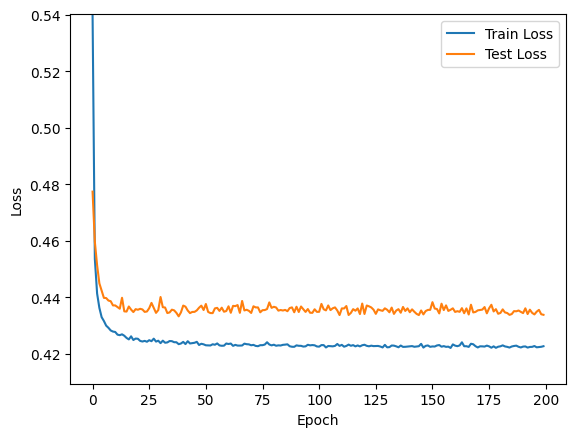

In [133]:
features = momentum_df[["startPosition", 
                        "binnedDriverAge_Middle", 
                        "binnedDriverAge_Old",
                        "binnedDriverExperience_Experienced",
                        "binnedDriverExperience_Veteran",
                        "binnedConstructorExperience_Experienced",
                        "top5Percent",
                        "top5Streak",
                        "lastAverageEndPosition",
                        "lastAveragePositionDelta"
                      ]].values
labels = momentum_df['inTop5']

X_train, X_test, Y_train, Y_test = train_test_split(features, labels, test_size=0.2, shuffle=True)

model = build_model(0.01, [10, 6, 1], activation="sigmoid", output_activation="sigmoid")
weight, bias, epochs, train_loss, test_loss = train_model(
    model, 
    X_train,
    Y_train,
    X_test,
    Y_test,
    epochs=200, 
    batch_size=300, 
)

plot_the_loss_curve(epochs, train_loss, test_loss)

Our overfitting looks worse here. However, our recall has gone up some.

#### ROC

127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 824us/step


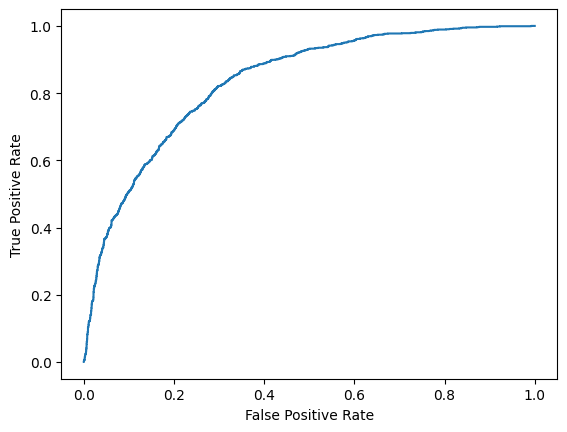

In [134]:
predictions = model.predict(X_test)
fpr, tpr, thresholds = roc_curve(Y_test, predictions)

plt.figure()
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

Our AUC is again comparable to before.

#### Confusion Matrix

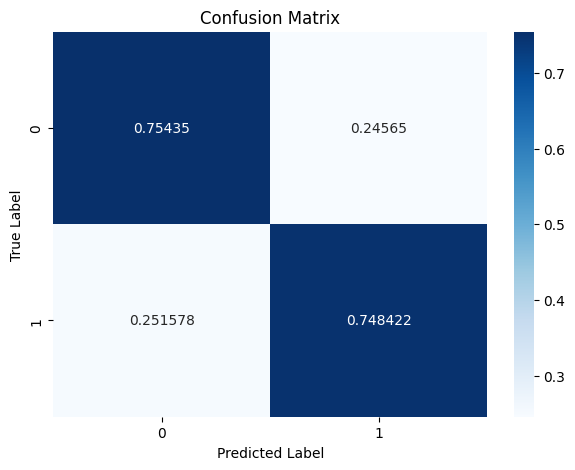

In [135]:
above_threshold = predictions > 0.3
confusion_matrix = tf.math.confusion_matrix(Y_test, above_threshold).numpy()
normalized_matrix = confusion_matrix / confusion_matrix.sum(axis=1, keepdims=True)
plt.figure(figsize=(7, 5))
sns.heatmap(normalized_matrix, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

This is a much more balanced model. Although our true positive rate has decreased a bit, it is more consistent between the two classes. However, we did have to tweak our threshold again. It would be great if we could find a way to make it so that we didn't have to compromise having a potentially high false positive rate for this in the future.

### Oversampling

Since our classes are imbalanced (25% True and 75% False), I'm curious what oversampling would do. Would this benefit our model by having more balanced classes?

In [136]:
momentum_df["inTop5"].value_counts()

inTop5
False    14585
True      5615
Name: count, dtype: int64

As expected, only ~25% are positive. Let's see if oversampling helps

In [137]:
from sklearn.utils import resample

positives = momentum_df[momentum_df['inTop5'] == True]
negatives = momentum_df[momentum_df['inTop5'] == False]

positives_resampled = resample(positives, replace=True, n_samples=len(negatives))

oversampled_df = pd.concat([positives_resampled, negatives])
oversampled_df = oversampled_df.sample(frac=1).reset_index(drop=True)
oversampled_df['inTop5'].value_counts()

inTop5
False    14585
True     14585
Name: count, dtype: int64

#### Model

Epoch 1/100


c:\Users\HADLEYHR23\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.6959 - auc: 0.7497 - loss: 0.6025 - precision: 0.6866 - recall: 0.7243 - val_accuracy: 0.7604 - val_auc: 0.8351 - val_loss: 0.5139 - val_precision: 0.7497 - val_recall: 0.7726
Epoch 2/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7563 - auc: 0.8328 - loss: 0.5102 - precision: 0.7573 - recall: 0.7565 - val_accuracy: 0.7609 - val_auc: 0.8371 - val_loss: 0.5048 - val_precision: 0.7355 - val_recall: 0.8052
Epoch 3/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7598 - auc: 0.8367 - loss: 0.5022 - precision: 0.7552 - recall: 0.7710 - val_accuracy: 0.7631 - val_auc: 0.8386 - val_loss: 0.5022 - val_precision: 0.7358 - val_recall: 0.8115
Epoch 4/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7622 - auc: 0.8373 - loss: 0.4999 - precision: 0.7535 - recall: 0.7815 - val_accuracy: 0.7611 - val_auc: 0.8399 - val_loss: 0.4987 - val_precision: 0.7640 - val_recall: 0.7465
Epoch 5/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/s

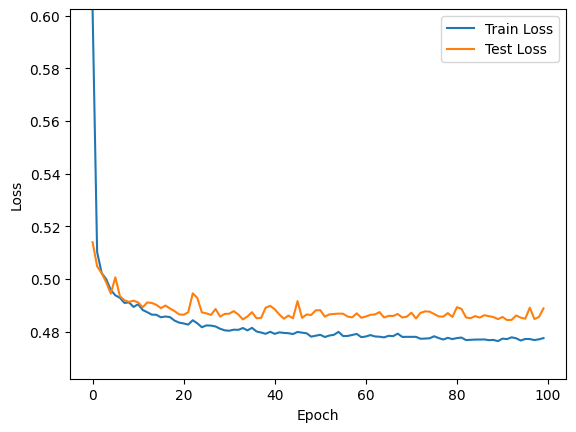

In [138]:
features = oversampled_df[["startPosition", 
                            "binnedDriverAge_Middle", 
                            "binnedDriverAge_Old",
                            "binnedDriverExperience_Experienced",
                            "binnedDriverExperience_Veteran",
                            "binnedConstructorExperience_Experienced",
                            "top5Percent",
                            "top5Streak",
                            "lastAverageEndPosition",
                            "lastAveragePositionDelta"
                      ]].values
labels = oversampled_df['inTop5']

X_train, X_test, Y_train, Y_test = train_test_split(features, labels, test_size=0.2, shuffle=True)

model = build_model(0.01, [10, 10, 10, 1], activation="sigmoid", output_activation="sigmoid")
weight, bias, epochs, train_loss, test_loss = train_model(
    model, 
    X_train,
    Y_train,
    X_test,
    Y_test,
    epochs=100, 
    batch_size=300, 
)

plot_the_loss_curve(epochs, train_loss, test_loss)

Our loss has decreased from before. We are again overfitting some, but we'll address that with regularization. Most notably though, our precision and recall have sky-rocketed from before. We're labeling a high amount of top 5 finishers as top 5 finishers.

#### ROC

183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 767us/step


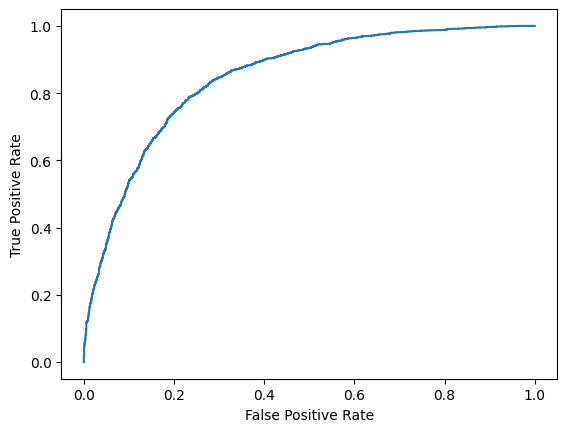

In [139]:
predictions = model.predict(X_test)
fpr, tpr, thresholds = roc_curve(Y_test, predictions)

plt.figure()
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

Our AUC is again comparable. But seeing that our recall and precision is better, I bet we don't need to adjust our threshold for the same results.

#### Confusion Matrix

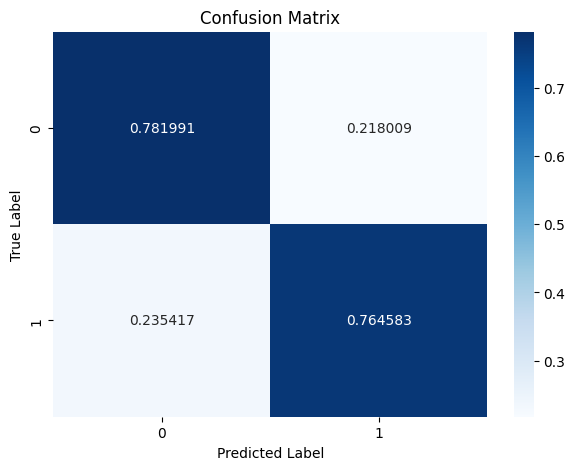

In [140]:
above_threshold = predictions > 0.5
confusion_matrix = tf.math.confusion_matrix(Y_test, above_threshold).numpy()
normalized_matrix = confusion_matrix / confusion_matrix.sum(axis=1, keepdims=True)
plt.figure(figsize=(7, 5))
sns.heatmap(normalized_matrix, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

Our threshold is also much more balanced, and our results are slightly better than before too. However, we are overfitting.

### Regularization

Let's address overfitting with an l2 regularization factor.

#### Model

Epoch 1/100


c:\Users\HADLEYHR23\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.6995 - auc: 0.7409 - loss: 0.6377 - precision: 0.7479 - recall: 0.6046 - val_accuracy: 0.7590 - val_auc: 0.8339 - val_loss: 0.5515 - val_precision: 0.7672 - val_recall: 0.7347
Epoch 2/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7539 - auc: 0.8308 - loss: 0.5331 - precision: 0.7558 - recall: 0.7524 - val_accuracy: 0.7623 - val_auc: 0.8369 - val_loss: 0.5214 - val_precision: 0.7533 - val_recall: 0.7708
Epoch 3/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7598 - auc: 0.8361 - loss: 0.5204 - precision: 0.7535 - recall: 0.7745 - val_accuracy: 0.7653 - val_auc: 0.8382 - val_loss: 0.5174 - val_precision: 0.7421 - val_recall: 0.8042
Epoch 4/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7608 - auc: 0.8369 - loss: 0.5164 - precision: 0.7543 - recall: 0.7757 - val_accuracy: 0.7640 - val_auc: 0.8389 - val_loss: 0.5141 - val_precision: 0.7434 - val_recall: 0.7969
Epoch 5/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/st

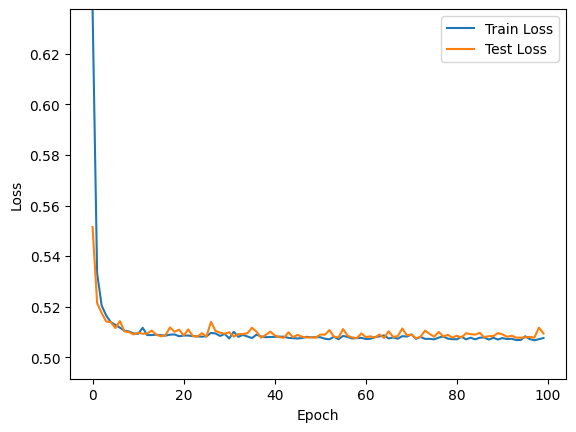

In [141]:
model = build_model(0.005, [10, 10, 10, 1], activation="sigmoid", output_activation="sigmoid", l2=0.0005)
weight, bias, epochs, train_loss, test_loss = train_model(
    model, 
    X_train,
    Y_train,
    X_test,
    Y_test,
    epochs=100, 
    batch_size=300, 
)

plot_the_loss_curve(epochs, train_loss, test_loss)

That's much better. Our regularization has removed overfitting.

#### ROC

183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 764us/step


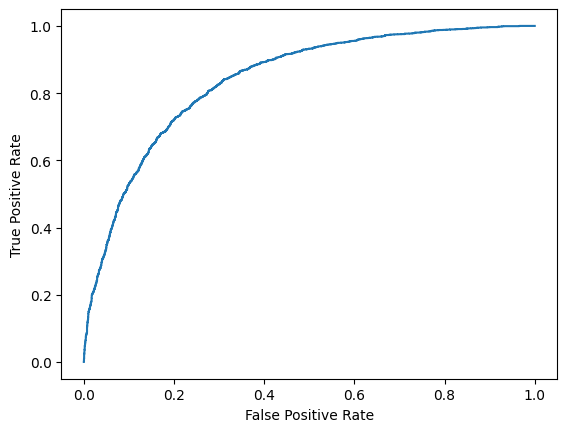

In [142]:
predictions = model.predict(X_test)
fpr, tpr, thresholds = roc_curve(Y_test, predictions)

plt.figure()
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

Again we have a comparable AUC. We've sacrificed a little bit, but to avoid overfitting, it's worth the cost.

#### Confusion Matrix

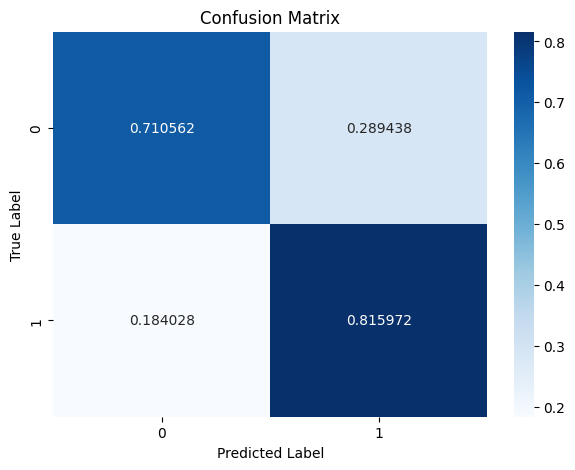

In [143]:
above_threshold = predictions > 0.5
confusion_matrix = tf.math.confusion_matrix(Y_test, above_threshold).numpy()
normalized_matrix = confusion_matrix / confusion_matrix.sum(axis=1, keepdims=True)
plt.figure(figsize=(7, 5))
sns.heatmap(normalized_matrix, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

That's a better true positive rate with a more balanced threshold than our original data. We're getting about the same results with regularization without overfitting. We've lost a bit with our true negative rate, but we're less likely to get a high false positive rate in the long term since our threshold is balanced.

Overall, we have seen how regularization, binning, synthetic features, and oversampling can help a model perform better. We only did some minor tweaking on our hidden layers. Changing the learning rate or the epochs or the batch size only did so much. But when we made the data better and gave the model better and more balanced data, it performed better.

## Overall Results
(Note that these numbers may not match with what is currently in the notebook. However, the numbers should be similar and still demonstrate what this table is trying to show.)
|Model Feature      |Threshold |TP rate |TN rate |FP rate |FN rate |
|-------------------|----------|--------|--------|--------|--------|
|Basic Data         |0.3       |0.74    |0.76    |0.24    |0.26    |
|Binning            |0.3       |0.73    |0.75    |0.25    |0.27    |
|Synthetic Features |0.3       |0.81    |0.73    |0.27    |0.19    |
|Oversampling       |0.5       |0.79    |0.76    |0.24    |0.21    |
|Regularization     |0.5       |0.80    |0.73    |0.27    |0.20    |

Synthetic features gave us the biggest boost in TP rate. Oversampling helped balanced our threshold. Regularization helped fix overfitting. Binning didn't ofer too much. It didn't increase our TP rate or TN rate by itself, but it could have helped in the long run to simplify our model. A model without binning would probably be more likely to overfit. 

In the end, we were able to make a model that correctly predicts if a driver will finish in the top 5, purely based on conditions known before the race occurs. Our model correctly identifies drivers that finish in the top 5 80% of the time, while correctly identifying drivers that don't finish in the top 5 73% of the time. This model is an improvement from our basic model based on true positive rate and the fact that we did not have to adjust our threshold lower to get a better rate. A balanced threshold ensures that we are not biased one way or the other. Our model also is an improvement from random guessing. If we randomly guessed on drivers (assuming 25% of the labels are true), we would see a true positive rate of 50% with a true negative rate of 66%. Guessing only true would grant a true positive rate of 100% with a true negative rate of 0%. Guessing only false would grant a true positive rate of 0% with a true negative rate of 100%. Our model does better than all of these.

## Predicting End Position
We've seen some decent results come out of our data with our synthetic variable and binned results. Let's see if we can also predict the specific spot using a softmax output.

In [144]:
import tensorflow as tf

def mean_reciprocal_rank(y_true, y_pred):
    y_pred = tf.convert_to_tensor(y_pred, dtype=tf.float32)
    y_true = tf.convert_to_tensor(y_true)

    sorted_indices = tf.argsort(y_pred, axis=1, direction='DESCENDING')

    total = 0.0
    for i in range(y_true.shape[1]):
        true_index = tf.argmax(y_true[i], output_type=tf.int32)
        rank = tf.where(sorted_indices[i] == true_index)[0][0] + 1 # 1-based ranking

        total += 1.0 / tf.cast(rank, dtype=float)

    return total / y_true.shape[1]

def build_categorical_model(learning_rate, layers, activation, output_activation, l2=0.0):
    """
    layers should be a list of integers describing the layers of the model. For instance, [4, 5, 3, 2] would describe
    a model with two hidden layers, the first having 5 neurons, and the second having 3 layers. The input layer would
    have 4 inputs, and the output layer would have 2 neurons.
    """

    model = tf.keras.models.Sequential()
    
    model.add(tf.keras.layers.Dense(
        layers[1], 
        activation=activation, 
        input_shape=(layers[0],),
        kernel_regularizer=tf.keras.regularizers.l2(l2)
    ))

    for i in range(2, len(layers) - 1):
        model.add(tf.keras.layers.Dense(
            layers[i], 
            activation=activation,
            kernel_regularizer=tf.keras.regularizers.l2(l2)
        ))

    model.add(tf.keras.layers.Dense(
        layers[len(layers) - 1], 
        activation=output_activation,
        kernel_regularizer=tf.keras.regularizers.l2(l2)
    ))
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                loss="categorical_crossentropy",
                metrics=[
                    'accuracy',
                    mean_reciprocal_rank
                    ]
                )

    return model

Epoch 1/100


c:\Users\HADLEYHR23\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


81/81 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.0878 - loss: 3.0147 - mean_reciprocal_rank: 0.2401 - val_accuracy: 0.1000 - val_loss: 2.9070 - val_mean_reciprocal_rank: 0.2689
Epoch 2/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.1055 - loss: 2.8844 - mean_reciprocal_rank: 0.2607 - val_accuracy: 0.0933 - val_loss: 2.8760 - val_mean_reciprocal_rank: 0.2677
Epoch 3/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1050 - loss: 2.8687 - mean_reciprocal_rank: 0.2666 - val_accuracy: 0.1050 - val_loss: 2.8650 - val_mean_reciprocal_rank: 0.2831
Epoch 4/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1095 - loss: 2.8590 - mean_reciprocal_rank: 0.2662 - val_accuracy: 0.1040 - val_loss: 2.8595 - val_mean_reciprocal_rank: 0.2839
Epoch 5/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.1086 - loss: 2.8555 - mean_reciprocal_rank: 0.2701 - val_accuracy: 0.1020 - val_loss: 2.8591 - val_mean_reciprocal_rank: 0.2822
Epoch 6/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/

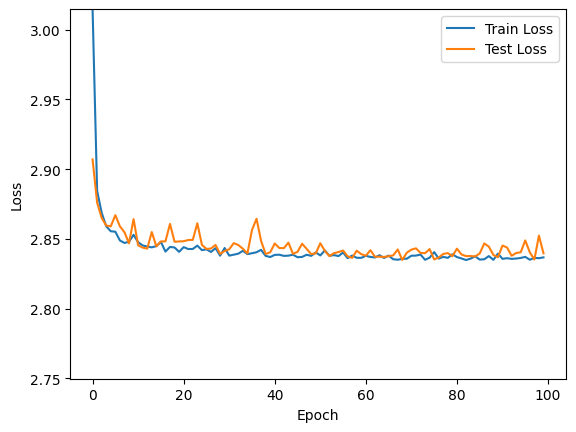

In [152]:
features = momentum_df[[
        "startPosition", 
        "binnedDriverAge_Middle", 
        "binnedDriverAge_Old", 
        "binnedDriverExperience_Experienced",
        "binnedDriverExperience_Veteran",
        "binnedConstructorExperience_Experienced",
        "top5Percent",
        "top5Streak",
        "lastAverageEndPosition",
        "lastAveragePositionDelta"
    ]].values
labels = pd.get_dummies(momentum_df['endPosition']).values

X_train, X_test, Y_train, Y_test = train_test_split(features, labels, test_size=0.2, shuffle=True)

model = build_categorical_model(0.006, [10, 50, 50, 50, 20], activation="sigmoid", output_activation="softmax", l2=0.001)

weight, bias, epochs, train_loss, test_loss = train_model(
                                                    model,
                                                    X_train,
                                                    Y_train,
                                                    X_test,
                                                    Y_test,
                                                    epochs=100,
                                                    batch_size=200,
                                                )

plot_the_loss_curve(epochs, train_loss, test_loss)

Although our accuracy is fairly poor that's not necessarily bad. For instance, our mean reciprocal rank tells us that on average, the correct rank is placed around the 5th spot. That would be consistent with our previous results. We can predict if a driver finishes in the top 5, so it makes sense that this model could extract that information too.

The accuracy metric here isn't super helpful. This is only measuring if we're predicting the exact endPosition correctly. Softmax outputs an array of the likelihoods that any one position would be ended on. So if our model puts the correct position as the second most likely spot, that's not necessarily incorrect. Let's see if we can find a way to see the rankings better.

### Top k Accuracies
It would be cool to see how accuract our model is with predicting the correct placement within the top k most likely end positions. For example, how good is our model at putting the correct prediction as the most likely spot? How good is our model at putting the correct prediction within the top two most likely spots? And so on...

127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


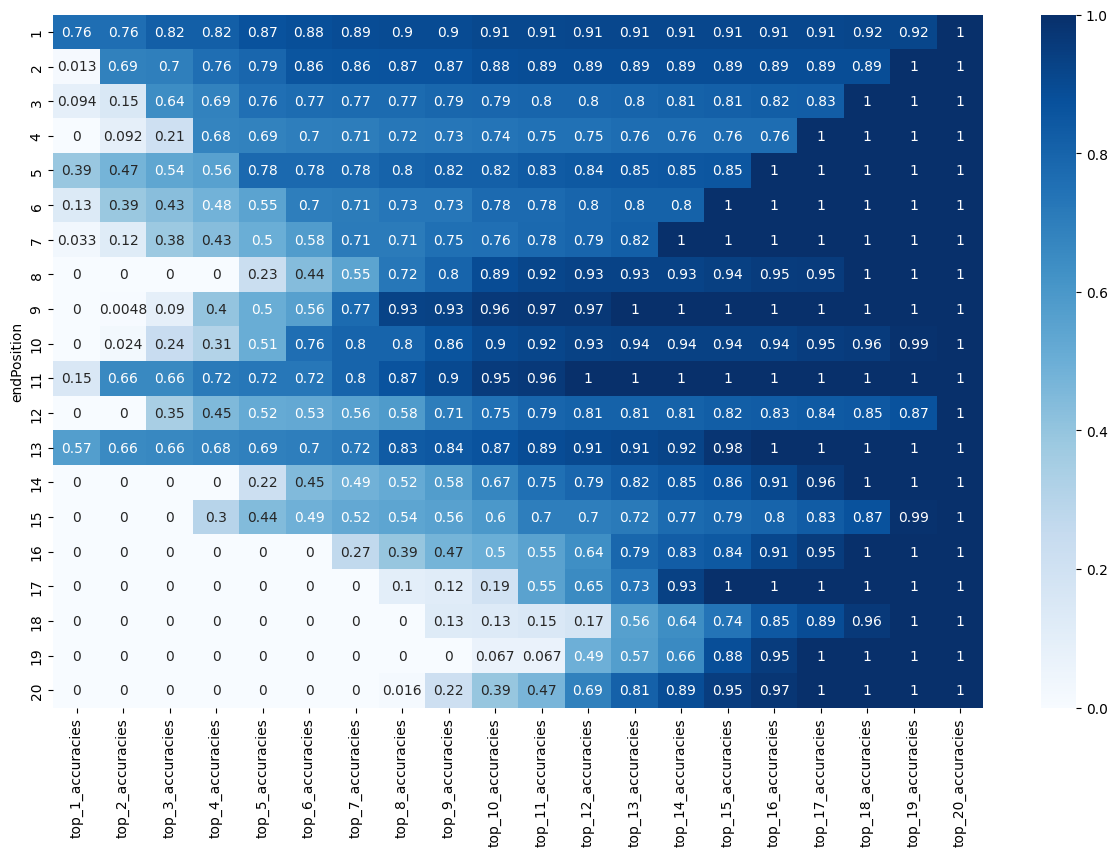

In [153]:
predictions = model.predict(X_test)
actuals = np.array([np.argmax(row) for row in Y_test])

accuracies = pd.DataFrame()
for k in range(1, 21):
    top_k_correct = pd.Series(tf.math.in_top_k(actuals, predictions, k))

    results = pd.DataFrame({'endPosition': actuals, 
                            f'top_{k}_correct': top_k_correct}).value_counts().reset_index(name='count')
    
    pivot_table = results.pivot_table(index='endPosition', columns=f'top_{k}_correct', values='count', fill_value=0)
    
    pivot_table = pivot_table.reindex(columns=[False, True], fill_value=0)

    accuracy = pivot_table[True] / (pivot_table[True] + pivot_table[False])

    accuracies[f"top_{k}_accuracies"] = accuracy


plt.figure(figsize=(15, 9))
ax = sns.heatmap(accuracies, cmap="Blues", annot=True)
ax.set_yticklabels([str(i) for i in range(1, 21)])
plt.show()

Based on that heatmap, the model performs well. We're predicting first place as the most likely position with an 84% accuracy. When we count labels being in the top 5 predictions as correct, we're getting accuracies in the 80-90% range for positions 1-5. Especially for positions 1-3 this is important in terms of F1 scoring. Positions 1-3 receive much more points (25, 18, 15) in comparision to the other positions (12, 10, 8, 6, 4, 2, 1, 1, ...). Similarly when we consider predicting the correct spot in the 10 most likely positions, we receive accuracies in the 80-90% range for positions 1-10. By the time we get to 11-20, the points are all the same, and end position doesn't matter significantly.

It is strange though that our model has a 48% accuracy when it comes to 12th place finishes as the most likely spot. Especially when compared to the other positions that have very low accuracies, this metric is surprising.

Let's look at a confusion matrix to see if we can gain anymore information about our model

### Top 1 Confusion Matrix

127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


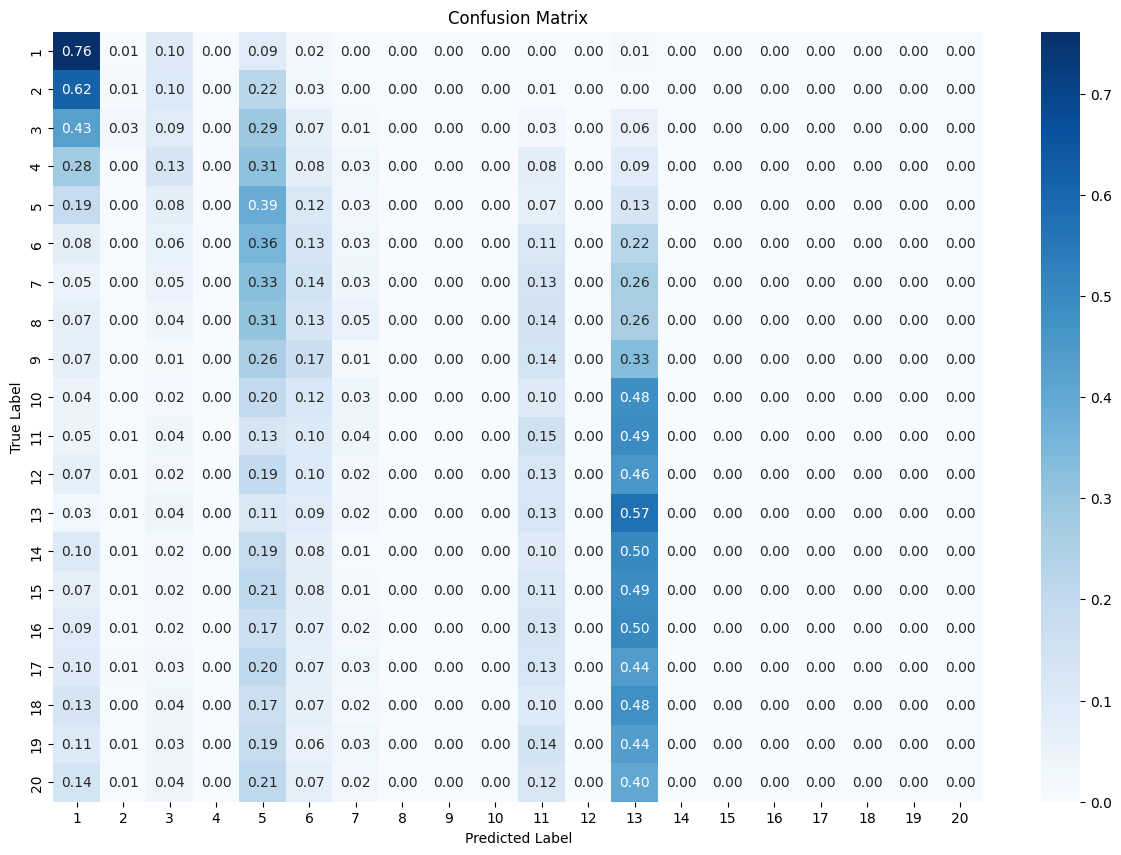

In [154]:
predictions = model.predict(X_test)
predictions = np.array([np.argmax(row) for row in predictions])
actuals = np.array([np.argmax(row) for row in Y_test])

confusion_matrix = tf.math.confusion_matrix(actuals, predictions).numpy()
normalized_matrix = confusion_matrix / confusion_matrix.sum(axis=1, keepdims=True)
plt.figure(figsize=(15, 10))
ax = sns.heatmap(normalized_matrix, annot=True, fmt='.2f', cmap='Blues')
ax.set_yticklabels([str(i) for i in range(1, 21)])
ax.set_xticklabels([str(i) for i in range(1, 21)])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

- As expected, we receive a fairly high tpr for first place. 
- We mislabel about half of the 2nd place finishers as 1st place finishers. 
- We never (or at least very rarely) predict a lot of the places, especially the lower half of places
- Although the graph changes for every model generated, there is a consistent pattern:
    - 1-3 labeled as 1
    - 4-8 labeled as a medium-high position (5-7)
    - 9-20 labeled as a medium-low positioni (12-17)

This makes some sense. It could be interesting to do binning on endPosition. For instance, instead of having 1-20, having 1-3, 4-9, 10-20. These bins come from the above data, but also the fact that points are high for 1-3, medium for 4-9, and fairly low for 10-20. We'll also bin startPosition to make it easier on the model.
## Binning

In [169]:
momentum_df['binnedStartPosition'] = pd.cut(momentum_df['startPosition'], right=True, bins=[0,3,8,20], labels=['Front', 'Middle', 'Back'])
momentum_df['binnedEndPosition'] = pd.cut(momentum_df['endPosition'], right=True, bins=[0,3,8,20], labels=['Front', 'Middle', 'Back'])

momentum_df = pd.get_dummies(momentum_df, columns=['binnedStartPosition'], drop_first=True)
momentum_df = pd.get_dummies(momentum_df, columns=['binnedEndPosition'], drop_first=False)
momentum_df.head()

,raceId,driverId,constructorId,startPosition,endPosition,constructorName,driverName,date,driverAge,driverExperience,...,binnedConstructorExperience_Experienced,top5Percent,top5Streak,lastAverageEndPosition,lastAveragePositionDelta,binnedStartPosition_Middle,binnedStartPosition_Back,binnedEndPosition_Front,binnedEndPosition_Middle,binnedEndPosition_Back
368,36,1,1,3,2,McLaren,Lewis Hamilton,2007-03-18,22.205479,0.000000,...,1,0.0,1,0.000000,0.00,False,False,True,False,False
390,37,1,1,3,1,McLaren,Lewis Hamilton,2007-04-08,22.263014,0.057534,...,1,0.2,2,2.000000,1.00,False,False,True,False,False
412,38,1,1,1,1,McLaren,Lewis Hamilton,2007-04-15,22.282192,0.076712,...,1,0.4,3,1.500000,1.50,False,False,True,False,False
434,39,1,1,3,1,McLaren,Lewis Hamilton,2007-05-13,22.358904,0.153425,...,1,0.6,4,1.333333,1.00,False,False,True,False,False
456,40,1,1,1,1,McLaren,Lewis Hamilton,2007-05-27,22.397260,0.191781,...,1,0.8,5,1.250000,1.25,False,False,True,False,False


In [170]:
momentum_df['binnedStartPosition_Middle'] = momentum_df['binnedStartPosition_Middle'].astype(int)
momentum_df['binnedStartPosition_Back']   = momentum_df['binnedStartPosition_Back'].astype(int)

momentum_df['binnedEndPosition_Front']    = momentum_df['binnedEndPosition_Front'].astype(int)
momentum_df['binnedEndPosition_Middle']   = momentum_df['binnedEndPosition_Middle'].astype(int)
momentum_df['binnedEndPosition_Back']     = momentum_df['binnedEndPosition_Back'].astype(int)
momentum_df.head()

,raceId,driverId,constructorId,startPosition,endPosition,constructorName,driverName,date,driverAge,driverExperience,...,binnedConstructorExperience_Experienced,top5Percent,top5Streak,lastAverageEndPosition,lastAveragePositionDelta,binnedStartPosition_Middle,binnedStartPosition_Back,binnedEndPosition_Front,binnedEndPosition_Middle,binnedEndPosition_Back
368,36,1,1,3,2,McLaren,Lewis Hamilton,2007-03-18,22.205479,0.000000,...,1,0.0,1,0.000000,0.00,0,0,1,0,0
390,37,1,1,3,1,McLaren,Lewis Hamilton,2007-04-08,22.263014,0.057534,...,1,0.2,2,2.000000,1.00,0,0,1,0,0
412,38,1,1,1,1,McLaren,Lewis Hamilton,2007-04-15,22.282192,0.076712,...,1,0.4,3,1.500000,1.50,0,0,1,0,0
434,39,1,1,3,1,McLaren,Lewis Hamilton,2007-05-13,22.358904,0.153425,...,1,0.6,4,1.333333,1.00,0,0,1,0,0
456,40,1,1,1,1,McLaren,Lewis Hamilton,2007-05-27,22.397260,0.191781,...,1,0.8,5,1.250000,1.25,0,0,1,0,0


Epoch 1/100


c:\Users\HADLEYHR23\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


81/81 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.5126 - loss: 0.9396 - mean_reciprocal_rank: 0.7380 - val_accuracy: 0.5188 - val_loss: 0.8888 - val_mean_reciprocal_rank: 0.7698
Epoch 2/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5180 - loss: 0.8620 - mean_reciprocal_rank: 0.7428 - val_accuracy: 0.5572 - val_loss: 0.8426 - val_mean_reciprocal_rank: 0.7646
Epoch 3/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5558 - loss: 0.8395 - mean_reciprocal_rank: 0.7558 - val_accuracy: 0.5480 - val_loss: 0.8356 - val_mean_reciprocal_rank: 0.7884
Epoch 4/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5691 - loss: 0.8332 - mean_reciprocal_rank: 0.7750 - val_accuracy: 0.5946 - val_loss: 0.8312 - val_mean_reciprocal_rank: 0.7963
Epoch 5/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5874 - loss: 0.8286 - mean_reciprocal_rank: 0.7997 - val_accuracy: 0.5938 - val_loss: 0.8251 - val_mean_reciprocal_rank: 0.7989
Epoch 6/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/

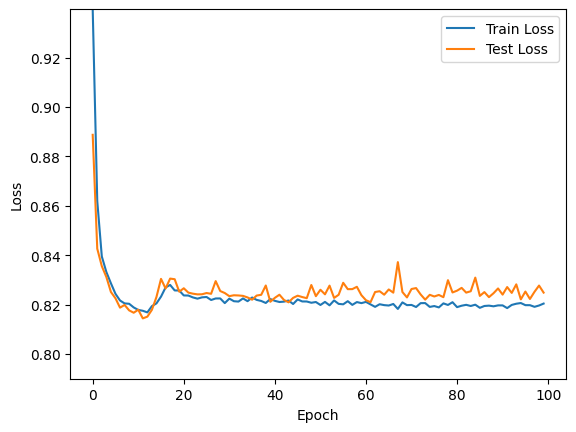

In [187]:
features = momentum_df[[
        "binnedStartPosition_Middle",
        "binnedStartPosition_Back", 
        "binnedDriverAge_Middle", 
        "binnedDriverAge_Old", 
        "binnedDriverExperience_Experienced",
        "binnedDriverExperience_Veteran",
        "binnedConstructorExperience_Experienced",
        "top5Percent",
        "top5Streak",
        "lastAverageEndPosition",
        "lastAveragePositionDelta"
    ]].values

labels = momentum_df[['binnedEndPosition_Front', 'binnedEndPosition_Middle', 'binnedEndPosition_Back']].values

X_train, X_test, Y_train, Y_test = train_test_split(features, labels, test_size=0.2, shuffle=True)

model = build_categorical_model(0.005, [11, 15, 11, 6, 3], activation="sigmoid", output_activation="softmax", l2=0.0)

weight, bias, epochs, train_loss, test_loss = train_model(
                                                    model,
                                                    X_train,
                                                    Y_train,
                                                    X_test,
                                                    Y_test,
                                                    epochs=100,
                                                    batch_size=200,
                                                )

plot_the_loss_curve(epochs, train_loss, test_loss)

127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


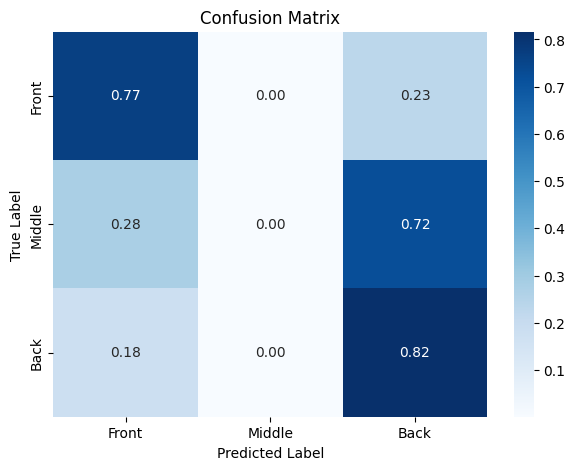

In [188]:
predictions = model.predict(X_test)
predictions = np.array([np.argmax(row) for row in predictions])
actuals = np.array([np.argmax(row) for row in Y_test])

confusion_matrix = tf.math.confusion_matrix(actuals, predictions).numpy()
normalized_matrix = confusion_matrix / confusion_matrix.sum(axis=1, keepdims=True)

plt.figure(figsize=(7, 5))
ax = sns.heatmap(normalized_matrix, annot=True, fmt='.2f', cmap='Blues')
ax.set_yticklabels(['Front', 'Middle', 'Back'])
ax.set_xticklabels(['Front', 'Middle', 'Back'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

We're not predicting middle positions ever. We're confusing the middles for the backs. That's actually not a huge issue though. We do have a 77% True positive rate for front places and an 82% true positive rate for back places. Interestingly we're confusing fronts for backs, but not fronts for middles.

This kind of leads us back to the beginning: a front and a back. We know we can make a model to predict if the driver will be in the top 5 which is essentially just predicting whether they'll be in the front or not. Interpreting the confusion matrix that way, this is essentially the same thing.

Our model for predicting top 5 seems to be more helpful than these other models we're exploring. Although it says less about the specific positioning, it's more powerful. It's more interpretalable based on the confusion matrix, and we can view things like the ROC curve. Ultimately, it doesn't matter a ton if someone comes in 10th or 11th, they both get the same amount of points. Measuring if they get top 5 though can be significant since these positions get the most points. This model isn't perfect, but it could be helpful.